# Selection of articles related to migration and word frequencies exploration

* Selection of migration-related articles by filtering with key words relative frequency threshold
* Evaluation of most common words in those selected topics per quarter after normalizing with TF-IDF
    * TF-IDF maximum and minimum frequencies are optimized through Grid Search
    * We will just consider 1-grams since in this case we are not making any semantic analysis but just finding most common words
    * TF-IDF was applied for each article and normalized over all the articles for the migration selection
    * The frequencies of words per quarter is done by averaging frequencies per quarter

In [1]:
import sys
import nltk
import re
import os
import requests
import datetime
sys.path.append("../..")
from src.helpers import google_translator, assign_quarter_labels, get_quarter_boundaries, articles_words_tokenization,\
                    articles_word_normalization, all_to_topic_articles, quantify_topic_articles_per_quarter,\
                    extract_mean_freq_words_quarter, articles_words_tokenization_annotation
from src.helpers import visualize_wordcloud, distribution_filtering, get_most_freq_words_quarter, \
                    build_reverse_stemming_mapper, get_most_freq_words_quarter, text_clean_summary
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.grid_search import ParameterGrid
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse as sp_sparse
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/celsadiaz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/Users/celsadiaz/.pyenv/versions/3.6.2/envs/nlp/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/celsadiaz/.pyenv/versions/3.6.2/envs/nlp/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Define text processing parameters

In [2]:
# Use the German stopwords.
stpwrds = stopwords.words("german")

# We added some additional characters to avoid.
characters = [',', '.', '(', ')', '!', ';', '-', ':', '...', '"',
                "''", "``", '~http', '?', '@', '#', '/', "'",
                '&', '--', '[', ']', '=', '||', '+', '_', '..',
                '%', '|', '~', 'http',"\n","—","•","“","„","–",
                "في","שראל","россии","не","минобороны","и","в",
                "את", "$",">","*"]

# Define key words for migration articles identification
vocabulary_target = ['einwander', 'fluchtling', 'rassismus', 'nationalismus', 'nationalsozialismus',
                     'rechtspopulismus','asyl','ertrink']
vocabulary_control = ['konsumismus', 'pflanze', 'gesundheit', 'vergewaltigt','osnabruck', 'london', 
                      'lobby', 'atomkrieg', 'lufthansa','gene', 'nordkorea', 'polizist', 'selbstmordanschlag', 
                      'rhine', 'america', 'der']

# Threshold to filter out low frequency on migration words articles
quartile = 2

# Define TF-IDF parameters for the text normalization
min_df = 20
max_df = 0.8
n_gram_min = 1
n_gram_max = 1

# Define quarter boundaries for period '12.02.2015'-'09.07.2018'
q1, q2, q3 = get_quarter_boundaries('2015')
q4, q5, q6 = get_quarter_boundaries('2016')
q7, q8, q9 = get_quarter_boundaries('2017')
q10, q11, q12 = get_quarter_boundaries('2018')
quarter_label_list = ['q1_15', 'q2_15', 'q3_15', 'q4_16', 'q5_16', 'q6_16', 'q7_17', 
                      'q8_17', 'q9_17', 'q10_18', 'q11_18']
title = ['Jan-Apr 2015', 'May-Aug 2015', 'Sep-Dec 2015', 'Jan-Apr 2016', 'May-Aug 2016', 'Sep-Dec 2016', 
         'Jan-Apr 2017', 'May-Aug 2017', 'Sep-Dec 2017', 'Jan-Apr 2018', 'May-Aug 2018']
quarter_bound_list = [q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,q11]

# Define wordcloud parameters
n_top_words = 300

### Clean articles (regex + stopwords + stemming) and filter migration related ones

In [3]:
# Load and format articles dataset
articles = pd.read_csv("../../data/articles_politic_all.csv")
articles["time_line"] = [x for x in reversed(range(len(articles)))]
articles.date = articles['date'].apply(lambda x: datetime.datetime.strptime(x, "%d.%m.%Y"))

# Label articles per quarter
articles = assign_quarter_labels(articles, quarter_bound_list, quarter_label_list)

In [5]:
# Clean summary page of the newspaper containing "DAS THEMA DES TAGES" or "DIE LAGE" or "SPIEGEL ONLINE"
articles["is_summary"] = articles["text"].apply(lambda x: text_clean_summary(x, characters))
articles = articles[articles["is_summary"] == 0]

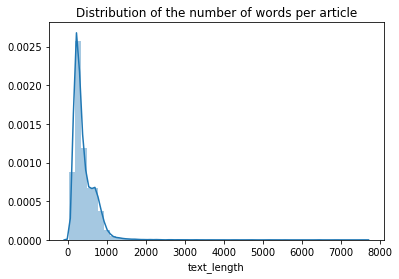

In [6]:
# Explore the distribution of number of words per article
articles['text_length'] = articles['text'].apply(lambda x: len(x.split(" ")))
_=sns.distplot(articles['text_length'])
_=plt.title("Distribution of the number of words per article")

### All articles to Migration topic selection filtering by key words frequency

In [7]:
# Calculate relative frequency of words per article after cleaning the text and removing stop words
# Normalization of frequencies over all the articles is not performed because we will get only 
# focused on key words frequencies
results = articles_words_tokenization_annotation(articles, vocabulary_target + vocabulary_control, stpwrds, 
                                                 characters)
resultsT = results.T

In [8]:
# Selection of articles that contain at least once one of the target key words related to migration
selectionT = resultsT[(resultsT["asyl"] > 0) | (resultsT["einwander"] > 0) | (resultsT["ertrink"] > 0) |\
         (resultsT["fluchtling"] > 0) | (resultsT["nationalismus"] > 0) | (resultsT["nationalsozialismus"] > 0) |\
         (resultsT["rassismus"] > 0) | (resultsT["rechtspopulismus"] > 0)].index.tolist()
selection = results.loc[:,(selectionT)]

In [9]:
print("The number of selected articles after the first filter is {} out of {}".format(len(selection.columns),
                                                                                     len(articles)))

The number of selected articles after the first filter is 5409 out of 26482


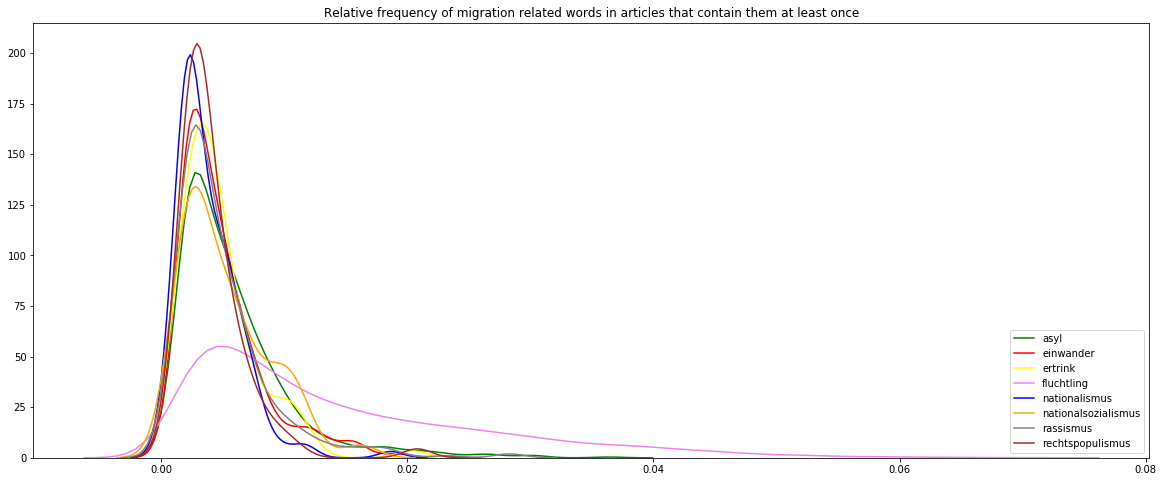

In [10]:
plt.figure(figsize=(20, 8))
sns.distplot([x for x in selection.loc["asyl"].tolist() if x > 0], hist=False, rug=False, color="green", label="asyl")
sns.distplot([x for x in selection.loc["einwander"].tolist() if x > 0], hist=False, rug=False, color="red", label="einwander")
sns.distplot([x for x in selection.loc["ertrink"].tolist() if x > 0], hist=False, rug=False, color="yellow", label="ertrink")
sns.distplot([x for x in selection.loc["fluchtling"].tolist() if x > 0], hist=False, rug=False, color="violet", label="fluchtling")
sns.distplot([x for x in selection.loc["nationalismus"].tolist() if x > 0], hist=False, rug=False, color="blue", label="nationalismus")
sns.distplot([x for x in selection.loc["nationalsozialismus"].tolist() if x > 0], hist=False, rug=False, color="orange", label="nationalsozialismus")
sns.distplot([x for x in selection.loc["rassismus"].tolist() if x > 0], hist=False, rug=False, color="gray", label="rassismus")
sns.distplot([x for x in selection.loc["rechtspopulismus"].tolist() if x > 0], hist=False, rug=False, color="brown", label="rechtspopulismus")
plt.title("Relative frequency of migration related words in articles that contain them at least once")
plt.legend(loc="lower right")

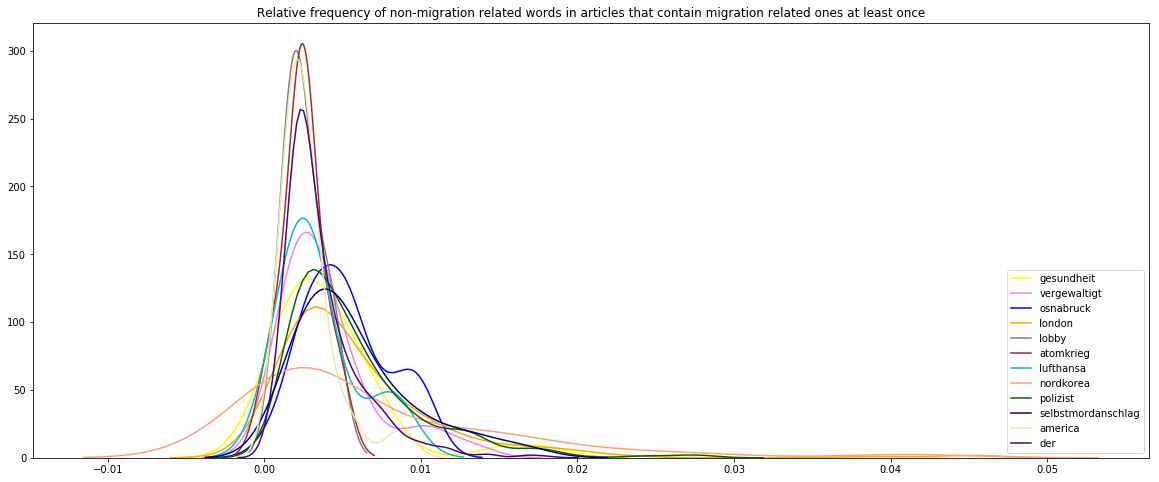

In [11]:
plt.figure(figsize=(20, 8))
sns.distplot([x for x in selection.loc["konsumismus"].tolist() if x > 0], hist=False, rug=False, color="green", label="konsumismus")
sns.distplot([x for x in selection.loc["pflanze"].tolist() if x > 0], hist=False, rug=False, color="red", label="pflanze")
sns.distplot([x for x in selection.loc["gesundheit"].tolist() if x > 0], hist=False, rug=False, color="yellow", label="gesundheit")
sns.distplot([x for x in selection.loc["vergewaltigt"].tolist() if x > 0], hist=False, rug=False, color="violet", label="vergewaltigt")
sns.distplot([x for x in selection.loc["osnabruck"].tolist() if x > 0], hist=False, rug=False, color="blue", label="osnabruck")
sns.distplot([x for x in selection.loc["london"].tolist() if x > 0], hist=False, rug=False, color="orange", label="london")
sns.distplot([x for x in selection.loc["lobby"].tolist() if x > 0], hist=False, rug=False, color="gray", label="lobby")
sns.distplot([x for x in selection.loc["atomkrieg"].tolist() if x > 0], hist=False, rug=False, color="brown", label="atomkrieg")
sns.distplot([x for x in selection.loc["lufthansa"].tolist() if x > 0], hist=False, rug=False, color="c", label="lufthansa")
sns.distplot([x for x in selection.loc["gene"].tolist() if x > 0], hist=False, rug=False, color="deeppink", label="gene")
sns.distplot([x for x in selection.loc["nordkorea"].tolist() if x > 0], hist=False, rug=False, color="lightsalmon", label="nordkorea")
sns.distplot([x for x in selection.loc["polizist"].tolist() if x > 0], hist=False, rug=False, color="darkgreen", label="polizist")
sns.distplot([x for x in selection.loc["selbstmordanschlag"].tolist() if x > 0], hist=False, rug=False, color="navy", label="selbstmordanschlag")
sns.distplot([x for x in selection.loc["rhine"].tolist() if x > 0], hist=False, rug=False, color="lime", label="rhine")
sns.distplot([x for x in selection.loc["america"].tolist() if x > 0], hist=False, rug=False, color="palegoldenrod", label="america")
sns.distplot([x for x in selection.loc["der"].tolist() if x > 0], hist=False, rug=False, color="indigo", label="der")
plt.title("Relative frequency of non-migration related words in articles that contain migration related ones at least once")
plt.legend(loc="lower right")

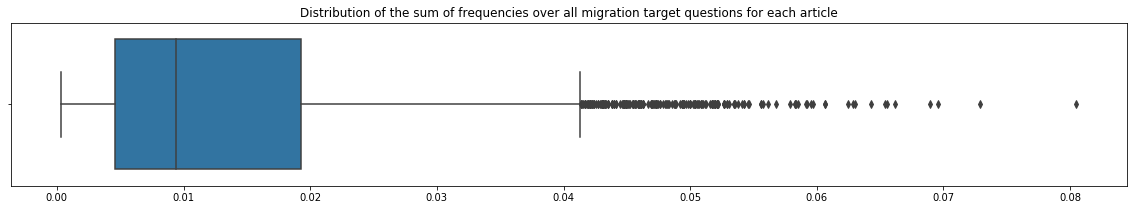

In [12]:
_=plt.figure(figsize=(20, 3))
_=sns.boxplot(selection.loc[vocabulary_target].sum(axis=0))
_=plt.title("Distribution of the sum of frequencies over all migration target questions for each article")

In [13]:
selection_complete = distribution_filtering(articles, selection, vocabulary_target, quartile)

Manual exploration shows that only those articles with a total target words frequency higher than the median (Q2) are totally focused on the topic migration.

Those articles with frequencies higher than the first quarter (Q1) contain sentences related to migration but as a side comment (i.e. US elections article where candidates mention briefly immigration as one of the main issues in the country within others). Therefore, they will not be considered.

In [14]:
selection_complete.to_csv("../../data/migration_articles.csv", index=False, encoding="utf-8")
print("We select {} articles that are mainly focused on migration-related topics.".format(len(selection_complete)))

We select 2705 articles that are mainly focused on migration-related topics.


In [15]:
selection_complete = pd.read_csv("../../data/migration_articles.csv")

### Evaluation of selected articles over time (amount and topics)

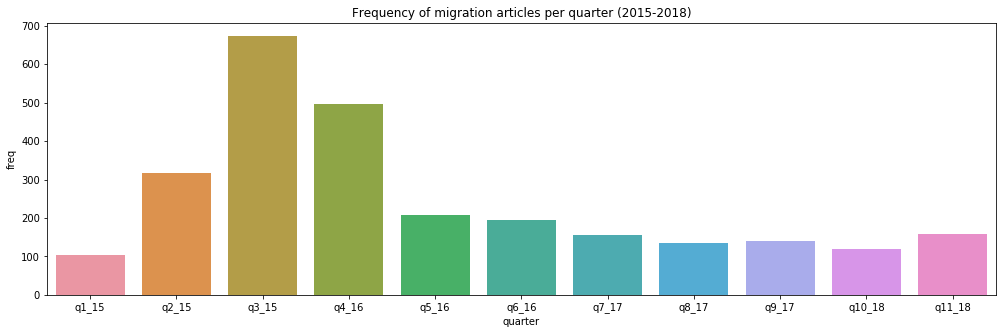

In [16]:
_=plt.figure(figsize=(17,5))
_=sns.barplot(y="freq",x="quarter",data=selection_complete.loc[:,("quarter","freq")].groupby(["quarter"], 
                                                                                    as_index=False).count(), 
            order=['q1_15', 'q2_15', 'q3_15', 'q4_16', 'q5_16', 
                   'q6_16', 'q7_17', 'q8_17', 'q9_17', 'q10_18', 'q11_18'])
_=plt.title("Frequency of migration articles per quarter (2015-2018)")

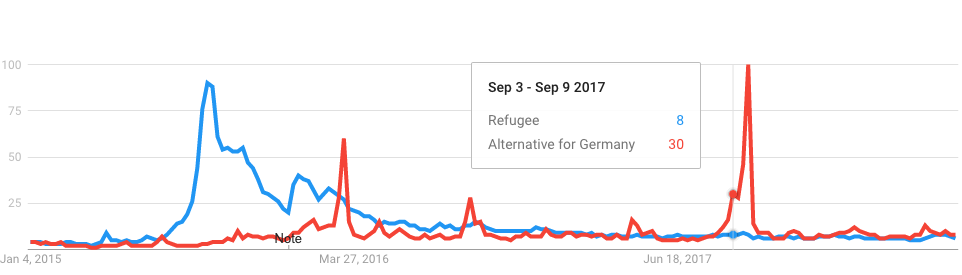

In [17]:
from IPython.display import Image
Image("../../img/refugee_afd_evolution.png")

We see the highest pick on number of topic related articles with the european refugee crisis in 2015.

A second wave comes with the pick observed for AfD in Google Treds picture. It could be related with the US elections and the rise of national socialism in US, France and Germany after the refugee crisis. There is a clear effect on the number of related articles in the last quarter of 2016.

It is not until the german national elections that we see again a pick on the amount of articles related to migration. It is in the same period than the huge pick of AfD searches in Google Treds.

Finally, we see a new growth on the number of articles in the most recent quarter, likely due to the current crisis in the Mediterranean See and the rejection of Italy and Malta to open their ports to the rescued refugees.

### Grid search the best parameters for word count normalization (TF-IDF)

In [18]:
articles_tokenized = articles_words_tokenization(selection_complete, stpwrds, characters)

In [19]:
articles_tokenized = articles_tokenized.drop(["article_id","text_length"], axis=1)

In [20]:
param_grid = {"min_df": [10, 30, 40, 50, 60, 80, 100, 200],
                "max_df": [0.5, 0.6, 0.7, 0.8, 0.9]}
grid = ParameterGrid(param_grid)

In [21]:
results_grid_search = []
for params in grid:
    try:
        results_grid = {}
        # from selected articles calculate normalized frequencies of words
        results_topic, resultsT_topic = articles_word_normalization(articles_tokenized, params["min_df"], 
                                                                    params["max_df"],n_gram_min, n_gram_max)
    
        # calculate metrics of selected words frequencies per quarter for the selected topic articles
        freqs_quarter, metrics = extract_mean_freq_words_quarter(resultsT_topic, articles_tokenized, 
                                                                 vocabulary_target, vocabulary_control)
        results_grid["min_df"] = params["min_df"]
        results_grid["max_df"] = params["max_df"]
        results_grid["freqs_quarter"] = freqs_quarter
        results_grid["metrics"] = metrics
        results_grid_search.append(results_grid)
    except:
        print("Combination of parameters min_df: {}, max_df: {} do not work."\
              .format(params['min_df'], params['max_df']))

Results have 2705 articles and 5642 normalized words
The frequencies for words: ['rechtspopulismus', 'nationalsozialismus', 'ertrink', 'rassismus', 'asyl', 'einwander', 'nationalismus']
is: [0.017974148918475024, 0.0044844284878120958, 0.0043184391170829105, 0.002036476121011948, 0.0013578360345402219, 0.00041826210282629032, 0.00036556075568101854]
The sum of the frequencies is: 0.03095515153742951
The frequencies for control words: ['london', 'gesundheit', 'vergewaltigt', 'polizist', 'selbstmordanschlag', 'der', 'osnabruck']
is: [0.0084606811388029442, 0.0028896486234100014, 0.0023042594158579014, 0.00091077796374653157, 0.0, 0.0, 0.0]
The sum of the frequencies is: 0.014565367141817378
The frequencies for words: ['rechtspopulismus', 'nationalsozialismus', 'nationalismus', 'rassismus', 'asyl', 'ertrink', 'einwander']
is: [0.017910703430887631, 0.0040427024739908739, 0.0033405920351766696, 0.0022775838453541605, 0.00052757450860867552, 0.00045474953299534177, 0.0]
The sum of the frequ

The frequencies for words: ['rassismus', 'einwander', 'asyl', 'ertrink']
is: [0.0048732450231420889, 0.0019954054778866764, 0.0014471850563203582, 0.0010227797034548379]
The sum of the frequencies is: 0.009338615260803962
The frequencies for control words: ['der', 'london', 'polizist']
is: [0.0061100752955230526, 0.0038226047963763566, 0.0015206929913849675]
The sum of the frequencies is: 0.011453373083284377
The frequencies for words: ['einwander', 'rassismus', 'ertrink', 'asyl']
is: [0.0038381132677421034, 0.0025526684305545205, 0.0016297662647782919, 0.0015067725866431854]
The sum of the frequencies is: 0.009527320549718101
The frequencies for control words: ['der', 'london', 'polizist']
is: [0.0044132401846264787, 0.002484467623161781, 0.0012062855835770117]
The sum of the frequencies is: 0.00810399339136527
The frequencies for words: ['rassismus', 'einwander', 'ertrink', 'asyl']
is: [0.0032159681028073933, 0.0025659270061897566, 0.0025124641681244821, 0.001172992739158524]
The sum

The frequencies for words: ['rassismus', 'asyl', 'ertrink', 'einwander']
is: [0.0064214067713196958, 0.0058827163097518904, 0.0035490268779418419, 0.0022489873210645986]
The sum of the frequencies is: 0.018102137280078028
The frequencies for control words: ['london', 'polizist', 'der']
is: [0.0061161949391223295, 0.0049548351536508354, 0.0]
The sum of the frequencies is: 0.011071030092773165
The frequencies for words: ['rassismus', 'asyl', 'ertrink', 'einwander']
is: [0.0061479000657686756, 0.0060635143807205565, 0.00098820755100805283, 0.00082435129476584918]
The sum of the frequencies is: 0.014023973292263134
The frequencies for control words: ['london', 'der', 'polizist']
is: [0.0087357345254374559, 0.0035592393595421253, 0.0034978264110067125]
The sum of the frequencies is: 0.015792800295986294
The frequencies for words: ['asyl', 'rassismus', 'einwander', 'ertrink']
is: [0.0071038235435527033, 0.0035182884726679309, 0.0018095614665458485, 0.00089780846877385875]
The sum of the freq

Results have 2705 articles and 1116 normalized words
The frequencies for words: ['einwander', 'rassismus', 'asyl']
is: [0.0089124261070289389, 0.0020965319513769759, 0.0008411050353860001]
The sum of the frequencies is: 0.011850063093791914
The frequencies for control words: ['polizist', 'der']
is: [0.003152188046465072, 0.0014017035127639921]
The sum of the frequencies is: 0.004553891559229064
The frequencies for words: ['einwander', 'rassismus', 'asyl']
is: [0.019511695430062589, 0.005936682618324739, 0.0037842391179395132]
The sum of the frequencies is: 0.029232617166326844
The frequencies for control words: ['polizist', 'der']
is: [0.0067946759386260389, 0.0028623064533389226]
The sum of the frequencies is: 0.009656982391964962
The frequencies for words: ['einwander', 'asyl', 'rassismus']
is: [0.0071398708199258603, 0.0051410874552207282, 0.0023823426269739515]
The sum of the frequencies is: 0.014663300902120539
The frequencies for control words: ['der', 'polizist']
is: [0.00360912

The frequencies for words: ['asyl']
is: [0.019163020585049619]
The sum of the frequencies is: 0.01916302058504962
The frequencies for control words: ['polizist', 'der']
is: [0.017240787570170057, 0.014132372898551826]
The sum of the frequencies is: 0.031373160468721885
The frequencies for words: ['asyl']
is: [0.022409360999632148]
The sum of the frequencies is: 0.022409360999632148
The frequencies for control words: ['polizist', 'der']
is: [0.017930524884540895, 0.012817710703358968]
The sum of the frequencies is: 0.030748235587899863
The frequencies for words: ['asyl']
is: [0.021422938888538322]
The sum of the frequencies is: 0.021422938888538322
The frequencies for control words: ['polizist', 'der']
is: [0.020906459660358794, 0.016258230589962765]
The sum of the frequencies is: 0.037164690250321555
The frequencies for words: ['asyl']
is: [0.013131581846820967]
The sum of the frequencies is: 0.013131581846820967
The frequencies for control words: ['polizist', 'der']
is: [0.02748133522

The frequencies for words: ['rechtspopulismus', 'rassismus', 'ertrink', 'asyl', 'nationalismus', 'einwander', 'nationalsozialismus']
is: [0.0087228028160939372, 0.002023516265782069, 0.001039570450265133, 0.00056612048760427253, 0.00046363221805773101, 0.0, 0.0]
The sum of the frequencies is: 0.012815642237803144
The frequencies for control words: ['vergewaltigt', 'selbstmordanschlag', 'polizist', 'gesundheit', 'london', 'der', 'osnabruck']
is: [0.0017624530912532267, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
The sum of the frequencies is: 0.0017624530912532267
Results have 2705 articles and 2582 normalized words
The frequencies for words: ['rassismus', 'einwander', 'ertrink', 'asyl']
is: [0.018008057269961929, 0.0091146985577530201, 0.0037121324687547689, 0.0029943830585047833]
The sum of the frequencies is: 0.0338292713549745
The frequencies for control words: ['polizist', 'london', 'der']
is: [0.0065998243500294601, 0.0, 0.0]
The sum of the frequencies is: 0.00659982435002946
The frequencies fo

The frequencies for words: ['ertrink', 'rassismus', 'asyl', 'einwander']
is: [0.0095998014881215343, 0.0067498459610089677, 0.0042569958503308226, 0.0030205758378483781]
The sum of the frequencies is: 0.023627219137309703
The frequencies for control words: ['der', 'london', 'polizist']
is: [0.0034728199219860372, 0.00063387740452252716, 0.0]
The sum of the frequencies is: 0.004106697326508564
The frequencies for words: ['ertrink', 'rassismus', 'asyl', 'einwander']
is: [0.013399779569687536, 0.0016319483336303764, 0.00093369696411451319, 0.00036911294208511375]
The sum of the frequencies is: 0.016334537809517536
The frequencies for control words: ['der', 'london', 'polizist']
is: [0.001281047627734234, 0.00050640411123269494, 0.0]
The sum of the frequencies is: 0.001787451738966929
The frequencies for words: ['ertrink', 'asyl', 'rassismus', 'einwander']
is: [0.010642100502778614, 0.006195160202245034, 0.0053736232101637953, 0.00031287412924865305]
The sum of the frequencies is: 0.022523

The frequencies for words: ['einwander', 'asyl', 'rassismus', 'ertrink']
is: [0.0057533139742950313, 0.0042743319661982127, 0.0025209751155516485, 0.0020587603024852827]
The sum of the frequencies is: 0.014607381358530175
The frequencies for control words: ['der', 'polizist']
is: [0.0050897131223115151, 0.0029658378165256754]
The sum of the frequencies is: 0.00805555093883719
The frequencies for words: ['einwander', 'ertrink', 'asyl', 'rassismus']
is: [0.0029724102351212263, 0.0022616435910758604, 0.0018241323840969075, 0.0]
The sum of the frequencies is: 0.007058186210293995
The frequencies for control words: ['polizist', 'der']
is: [0.0025280727923628777, 0.001148405716203061]
The sum of the frequencies is: 0.003676478508565939
The frequencies for words: ['ertrink', 'rassismus', 'einwander', 'asyl']
is: [0.0035703702086211484, 0.001389143234583727, 0.0007665683076251656, 0.00048426892034202578]
The sum of the frequencies is: 0.006210350671172067
The frequencies for control words: ['d

The frequencies for words: ['rassismus', 'asyl', 'einwander']
is: [0.0053993774701392204, 0.0040451973455343689, 0.0023337109375639394]
The sum of the frequencies is: 0.011778285753237527
The frequencies for control words: ['der', 'polizist']
is: [0.01119212336731723, 0.0029451266035892465]
The sum of the frequencies is: 0.014137249970906478
The frequencies for words: ['asyl', 'einwander', 'rassismus']
is: [0.013674357433016126, 0.0037381723688826251, 0.0034205306499976314]
The sum of the frequencies is: 0.020833060451896382
The frequencies for control words: ['der', 'polizist']
is: [0.046009505989514171, 0.0029866027247695249]
The sum of the frequencies is: 0.0489961087142837
Results have 2705 articles and 416 normalized words
The frequencies for words: ['asyl']
is: [0.010670163697556693]
The sum of the frequencies is: 0.010670163697556693
The frequencies for control words: ['polizist', 'der']
is: [0.030643900041273202, 0.020867579304832781]
The sum of the frequencies is: 0.0515114793

The frequencies for words: ['rechtspopulismus', 'asyl', 'rassismus', 'nationalsozialismus', 'einwander', 'nationalismus', 'ertrink']
is: [0.014595935459602936, 0.0082844192024545942, 0.0022641923419615727, 0.0013888392953249524, 0.00042825745100235924, 0.0, 0.0]
The sum of the frequencies is: 0.026961643750346414
The frequencies for control words: ['vergewaltigt', 'polizist', 'london', 'selbstmordanschlag', 'osnabruck', 'der', 'gesundheit']
is: [0.0011955792857156627, 0.00086756215372289737, 0.00072917707269973459, 0.0, 0.0, 0.0, 0.0]
The sum of the frequencies is: 0.0027923185121382947
The frequencies for words: ['rechtspopulismus', 'asyl', 'ertrink', 'rassismus', 'einwander', 'nationalismus', 'nationalsozialismus']
is: [0.017472964136809988, 0.0074993643605646698, 0.0043000988542735855, 0.0035946082791544708, 0.0016722086315649378, 0.00097955555106975668, 0.0]
The sum of the frequencies is: 0.03551879981343741
The frequencies for control words: ['polizist', 'london', 'vergewaltigt', 

The frequencies for words: ['ertrink', 'rassismus', 'einwander', 'asyl']
is: [0.022646704218327658, 0.004103130227355662, 0.0025168696425979893, 0.0021049105170108944]
The sum of the frequencies is: 0.031371614605292204
The frequencies for control words: ['der', 'polizist', 'london']
is: [0.012212206298144452, 0.0052937935126048481, 0.0026683416749262688]
The sum of the frequencies is: 0.020174341485675568
The frequencies for words: ['ertrink', 'rassismus', 'asyl', 'einwander']
is: [0.026897195134458936, 0.0069502465148259208, 0.0020098219171455264, 0.0017284802993981488]
The sum of the frequencies is: 0.03758574386582853
The frequencies for control words: ['polizist', 'der', 'london']
is: [0.018559325288284381, 0.011411568713438567, 0.001497335455161324]
The sum of the frequencies is: 0.03146822945688427
The frequencies for words: ['ertrink', 'rassismus', 'asyl', 'einwander']
is: [0.0071433080178776647, 0.004805835891648149, 0.0019532349145488298, 0.00082114459554598362]
The sum of th

The frequencies for words: ['ertrink', 'asyl', 'einwander', 'rassismus']
is: [0.02124419368516926, 0.0060510728250535821, 0.0018300971552484642, 0.00058685981455761408]
The sum of the frequencies is: 0.02971222348002892
The frequencies for control words: ['der', 'polizist']
is: [0.0089516780080862359, 0.0064874233030149308]
The sum of the frequencies is: 0.015439101311101166
The frequencies for words: ['ertrink', 'einwander', 'asyl', 'rassismus']
is: [0.013605108609852767, 0.0056297953996091591, 0.0024028837533337185, 0.0011097538754010507]
The sum of the frequencies is: 0.022747541638196696
The frequencies for control words: ['der', 'polizist']
is: [0.0062369497940486379, 0.0037409977590845403]
The sum of the frequencies is: 0.009977947553133179
The frequencies for words: ['asyl', 'ertrink', 'rassismus', 'einwander']
is: [0.0081059590744321057, 0.0071253147618987097, 0.003189672474154442, 0.0027748165119136923]
The sum of the frequencies is: 0.021195762822398947
The frequencies for co

The frequencies for words: ['rassismus', 'asyl', 'einwander']
is: [0.010913871787846153, 0.0058995281639178604, 0.00063940256731212129]
The sum of the frequencies is: 0.017452802519076136
The frequencies for control words: ['der', 'polizist']
is: [0.0085736412335306877, 0.0038108336887899834]
The sum of the frequencies is: 0.01238447492232067
The frequencies for words: ['rassismus', 'asyl', 'einwander']
is: [0.0099151575092057721, 0.0063527860064070737, 0.0056908360593424046]
The sum of the frequencies is: 0.021958779574955248
The frequencies for control words: ['der', 'polizist']
is: [0.0086047766784982573, 0.0058168754240126574]
The sum of the frequencies is: 0.014421652102510915
The frequencies for words: ['einwander', 'rassismus', 'asyl']
is: [0.016299770258984287, 0.0060027371226610083, 0.0053421467803110925]
The sum of the frequencies is: 0.027644654161956387
The frequencies for control words: ['der', 'polizist']
is: [0.0082129918565522191, 0.0071294295092852941]
The sum of the f

The frequencies for words: ['rechtspopulismus', 'ertrink', 'rassismus', 'nationalsozialismus', 'einwander', 'nationalismus', 'asyl']
is: [0.0097330750654461839, 0.007125922017512408, 0.0025020646866224161, 0.0015619537493673115, 0.0009797431634689718, 0.00097528585958404045, 9.6433027739666497e-05]
The sum of the frequencies is: 0.022974477569741
The frequencies for control words: ['osnabruck', 'london', 'selbstmordanschlag', 'der', 'gesundheit', 'vergewaltigt', 'polizist']
is: [0.004186302702772305, 0.0036208421834339, 0.00082438277153180656, 0.0006357329454792271, 0.00053859083886023261, 0.00034244107812188073, 0.00013682276163976695]
The sum of the frequencies is: 0.01028511528183912
The frequencies for words: ['rechtspopulismus', 'ertrink', 'rassismus', 'nationalismus', 'nationalsozialismus', 'einwander', 'asyl']
is: [0.0094087866606181667, 0.0042627111929454857, 0.0018336025709980777, 0.0012145233791559375, 0.00097425888192978721, 0.00077310258741542068, 0.00045234013966562067]
Th

The frequencies for words: ['rassismus', 'einwander', 'ertrink', 'asyl']
is: [0.0085198728195785244, 0.0082525669449097627, 0.0064424161546466335, 0.0031936597442177488]
The sum of the frequencies is: 0.02640851566335267
The frequencies for control words: ['polizist', 'london', 'der']
is: [0.0009199756688154278, 0.00046852775020262539, 0.0]
The sum of the frequencies is: 0.0013885034190180532
The frequencies for words: ['einwander', 'ertrink', 'rassismus', 'asyl']
is: [0.011916335332693838, 0.0057830123713950993, 0.0048454246644651219, 0.0040678209515304696]
The sum of the frequencies is: 0.02661259332008453
The frequencies for control words: ['london', 'polizist', 'der']
is: [0.0092158252266715691, 0.0031974199556038295, 0.0024887952390497381]
The sum of the frequencies is: 0.014902040421325138
Results have 2705 articles and 2071 normalized words
The frequencies for words: ['ertrink', 'rassismus', 'asyl', 'einwander']
is: [0.03204254954482115, 0.0038310630513114928, 0.0014275335957270

The frequencies for words: ['einwander', 'ertrink', 'rassismus', 'asyl']
is: [0.020907793912595351, 0.0026020526162253677, 0.0024765633017842232, 0.0014258118285198618]
The sum of the frequencies is: 0.027412221659124804
The frequencies for control words: ['london', 'der', 'polizist']
is: [0.0069240585792009895, 0.0039982514025089207, 0.0021159988415792824]
The sum of the frequencies is: 0.013038308823289192
The frequencies for words: ['einwander', 'asyl', 'ertrink', 'rassismus']
is: [0.017302566019023417, 0.0026371369623410007, 0.0020090183155509608, 0.0012956486276465484]
The sum of the frequencies is: 0.023244369924561928
The frequencies for control words: ['london', 'polizist', 'der']
is: [0.0063013465959516702, 0.0034987614350634991, 0.002700422738124774]
The sum of the frequencies is: 0.012500530769139944
The frequencies for words: ['einwander', 'rassismus', 'ertrink', 'asyl']
is: [0.018115175235979337, 0.003704312805964902, 0.0016327753709999627, 0.0]
The sum of the frequencies 

The frequencies for words: ['rassismus', 'einwander', 'asyl']
is: [0.012586859080488771, 0.010873860732443393, 0.0023302064676405032]
The sum of the frequencies is: 0.025790926280572668
The frequencies for control words: ['der', 'polizist']
is: [0.0047285859421277538, 0.0036156889752773699]
The sum of the frequencies is: 0.008344274917405123
The frequencies for words: ['rassismus', 'einwander', 'asyl']
is: [0.01310666410616438, 0.0058299372738045228, 0.0023620106952309881]
The sum of the frequencies is: 0.02129861207519989
The frequencies for control words: ['polizist', 'der']
is: [0.0026752805256881665, 0.0013142252440914355]
The sum of the frequencies is: 0.003989505769779602
The frequencies for words: ['rassismus', 'einwander', 'asyl']
is: [0.010361279344444092, 0.0071059255884845796, 0.00065651065979099095]
The sum of the frequencies is: 0.018123715592719664
The frequencies for control words: ['polizist', 'der']
is: [0.0054219220595287335, 0.002579046173677913]
The sum of the frequ

Results have 2705 articles and 5650 normalized words
The frequencies for words: ['rechtspopulismus', 'rassismus', 'ertrink', 'nationalsozialismus', 'einwander', 'asyl', 'nationalismus']
is: [0.017845884757470128, 0.0049420936048029402, 0.0035277784377387889, 0.001854159821858221, 0.00089721960445394424, 0.0, 0.0]
The sum of the frequencies is: 0.02906713622632402
The frequencies for control words: ['london', 'der', 'polizist', 'selbstmordanschlag', 'gesundheit', 'osnabruck', 'vergewaltigt']
is: [0.0055002835507156804, 0.00091676193945766193, 0.00085918190126256066, 0.0, 0.0, 0.0, 0.0]
The sum of the frequencies is: 0.007276227391435903
The frequencies for words: ['rechtspopulismus', 'ertrink', 'rassismus', 'nationalismus', 'nationalsozialismus', 'einwander', 'asyl']
is: [0.017784008109997688, 0.0032115651640860724, 0.0015743243860926706, 0.0013229905796948351, 0.000879843187169348, 0.0, 0.0]
The sum of the frequencies is: 0.02477273142704061
The frequencies for control words: ['london'

The frequencies for words: ['ertrink', 'einwander', 'rassismus', 'asyl']
is: [0.0078448409827212122, 0.0069968401292390004, 0.0042096824421000399, 0.0015197117311776434]
The sum of the frequencies is: 0.020571075285237893
The frequencies for control words: ['der', 'polizist', 'london']
is: [0.012543043472926259, 0.002378143927886153, 0.0011038627106427826]
The sum of the frequencies is: 0.016025050111455195
The frequencies for words: ['ertrink', 'einwander', 'rassismus', 'asyl']
is: [0.0084438511589607825, 0.0076371588999659757, 0.0032964456351926613, 0.0026130711654805193]
The sum of the frequencies is: 0.02199052685959994
The frequencies for control words: ['london', 'der', 'polizist']
is: [0.0051495592648090113, 0.0039609659496820096, 0.0028421550090446421]
The sum of the frequencies is: 0.011952680223535662
The frequencies for words: ['einwander', 'ertrink', 'rassismus', 'asyl']
is: [0.011476403785721685, 0.0044050761525590235, 0.0020652455951579675, 0.0015683704070040523]
The sum 

The frequencies for words: ['einwander', 'ertrink', 'asyl', 'rassismus']
is: [0.013886553829650318, 0.003523218946508414, 0.0023762071064133412, 0.0014198673886257572]
The sum of the frequencies is: 0.02120584727119783
The frequencies for control words: ['der', 'london', 'polizist']
is: [0.0049665109735778168, 0.0049364573007951553, 0.0019768001161421136]
The sum of the frequencies is: 0.011879768390515086
The frequencies for words: ['einwander', 'asyl', 'rassismus', 'ertrink']
is: [0.017333246981631471, 0.0022791338826423195, 0.0015086883607017291, 0.00097392697007283539]
The sum of the frequencies is: 0.022094996195048355
The frequencies for control words: ['der', 'london', 'polizist']
is: [0.0028548157925119264, 0.0017717612778812759, 0.0015345624577964882]
The sum of the frequencies is: 0.00616113952818969
The frequencies for words: ['einwander', 'rassismus', 'asyl', 'ertrink']
is: [0.024093554024335322, 0.0042278033077119163, 0.0011410895722987308, 0.0008873977200908106]
The sum o

Results have 2705 articles and 1124 normalized words
The frequencies for words: ['rassismus', 'asyl', 'einwander']
is: [0.011583931598100391, 0.0042924478816245594, 0.0029539230516317976]
The sum of the frequencies is: 0.018830302531356747
The frequencies for control words: ['der', 'polizist']
is: [0.0025489206739471764, 0.0004315250791130748]
The sum of the frequencies is: 0.0029804457530602513
The frequencies for words: ['rassismus', 'einwander', 'asyl']
is: [0.014821425473920137, 0.0013901096491628529, 0.001160796618733781]
The sum of the frequencies is: 0.017372331741816772
The frequencies for control words: ['der', 'polizist']
is: [0.0036395995853117911, 0.0019245224313027794]
The sum of the frequencies is: 0.00556412201661457
The frequencies for words: ['asyl', 'einwander', 'rassismus']
is: [0.011724240350729791, 0.0067693924426821392, 0.0055322446479991556]
The sum of the frequencies is: 0.024025877441411086
The frequencies for control words: ['der', 'polizist']
is: [0.006818477

The frequencies for words: ['asyl']
is: [0.019450234749047102]
The sum of the frequencies is: 0.019450234749047102
The frequencies for control words: ['der', 'polizist']
is: [0.026818412109580574, 0.016765229209854373]
The sum of the frequencies is: 0.04358364131943494
The frequencies for words: ['asyl']
is: [0.017277308431034966]
The sum of the frequencies is: 0.017277308431034966
The frequencies for control words: ['der', 'polizist']
is: [0.021676020212904507, 0.017368284880954338]
The sum of the frequencies is: 0.039044305093858846
The frequencies for words: ['asyl']
is: [0.016231608948267313]
The sum of the frequencies is: 0.016231608948267313
The frequencies for control words: ['der', 'polizist']
is: [0.027142787705544062, 0.020215409598021945]
The sum of the frequencies is: 0.04735819730356601
The frequencies for words: ['asyl']
is: [0.021642307653603369]
The sum of the frequencies is: 0.02164230765360337
The frequencies for control words: ['der', 'polizist']
is: [0.0280227511836

In [22]:
# shape grid search results
results_gs = []
for i in range(len(results_grid_search)):
    df = pd.DataFrame.from_records(results_grid_search[i]["metrics"]).mean()
    df["max_df"] = results_grid_search[i]["max_df"]
    df["min_df"] = results_grid_search[i]["min_df"]
    results_gs.append(df)
df_results_gs = pd.concat(results_gs, axis=1).T
df_results_gs["diff_freqs"] = df_results_gs["total_freqs"] - df_results_gs["total_freqs_c"]

In [23]:
# Choose the parameters for a highest freq on target words and a highest difference between
# freq of target words and control ones
df_results_gs = df_results_gs.sort_values(by=["total_freqs"])
df_results_gs.to_csv("../../data/tf-idf_gs_results.csv", index=False, encoding='utf-8')

In [24]:
df_results_gs = pd.read_csv("../../data/tf-idf_gs_results.csv")
df_results_gs.tail(10)

,control_perc,target_perc,total_freqs,total_freqs_c,max_df,min_df,diff_freqs
30,18.75,50.0,0.024904,0.010661,0.8,40.0,0.014243
31,12.50,37.5,0.025107,0.018003,0.6,100.0,0.007103
32,18.75,50.0,0.025656,0.021214,0.7,40.0,0.004443
33,18.75,50.0,0.026038,0.004801,0.6,40.0,0.021237
34,18.75,50.0,0.026245,0.010986,0.5,40.0,0.015259
35,12.50,12.5,0.029221,0.039088,0.7,200.0,-0.009868
36,12.50,50.0,0.029857,0.033589,0.5,60.0,-0.003731
37,12.50,37.5,0.030848,0.017994,0.5,100.0,0.012853
38,12.50,37.5,0.040547,0.008818,0.8,100.0,0.031729
39,12.50,37.5,0.040547,0.008818,0.9,100.0,0.031729


The combination of parameters that results in a most clear wordcloud representation is that one that obtain:
* High difference between percentage of appearance on key words against control words
* High difference between sum of frequencies of key words against control words
* High percentage of appearance on key words
* High sum of frequencies of key words

The best compromise is that one in index 34

#### Run word normalization with best parameters and extract most common words per quarter

In [25]:
min_df = 40
max_df = 0.5

In [26]:
# from selected articles calculate normalized frequencies of words
results_topic, resultsT_topic = articles_word_normalization(articles_tokenized, min_df, 
                                                            max_df,n_gram_min, n_gram_max)
    
# calculate metrics of selected words frequencies per quarter for the selected topic articles
freqs_quarter, metrics = extract_mean_freq_words_quarter(resultsT_topic, articles_tokenized, 
                                                        vocabulary_target, vocabulary_control)

Results have 2705 articles and 2063 normalized words
The frequencies for words: ['ertrink', 'rassismus', 'asyl', 'einwander']
is: [0.032392327342686961, 0.0053302312281210511, 0.003400196987733081, 0.0]
The sum of the frequencies is: 0.0411227555585411
The frequencies for control words: ['der', 'london', 'polizist']
is: [0.0088947714251927257, 0.0014742487576042305, 0.0]
The sum of the frequencies is: 0.010369020182796956
The frequencies for words: ['ertrink', 'asyl', 'rassismus', 'einwander']
is: [0.016391285871376088, 0.0033676403508419435, 0.0016631393491873443, 0.0011344765210231527]
The sum of the frequencies is: 0.02255654209242853
The frequencies for control words: ['london', 'der', 'polizist']
is: [0.0047498995338998463, 0.0039861707624888124, 0.0019593114254661216]
The sum of the frequencies is: 0.010695381721854781
The frequencies for words: ['ertrink', 'rassismus', 'asyl', 'einwander']
is: [0.019606697972384846, 0.0079843719360913959, 0.004742703407056445, 0.0]
The sum of th

### Visualization of most common words per quarter by reverse stemming

In [27]:
stemming_mapper = build_reverse_stemming_mapper(selection_complete, characters, stpwrds)

In [28]:
fobidenwords = ['freq','verabschiedet','januar','februar', 'märz', 'april', 'mai', 'juni', 'juli', 'august',
                'september', 'oktober', 'november', 'dezember', 'montag', 'dienstag', 'mittwoch','donnerstag',
                'freitag', 'samstag', 'sonntag', 'morgen', 'abend']

In [29]:
freqs_quarter_ = freqs_quarter[~(freqs_quarter['word'].isin(fobidenwords))]

In [30]:
dict_freqs_quarter = get_most_freq_words_quarter(freqs_quarter_, n_top_words, stemming_mapper)

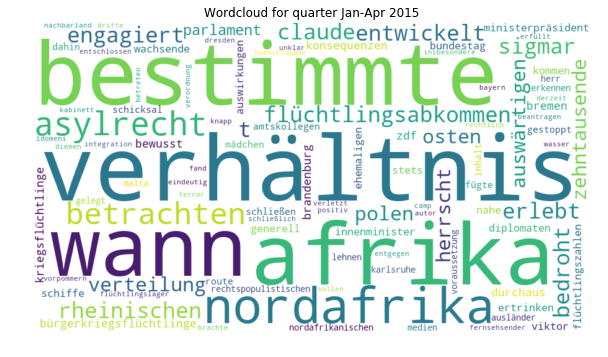

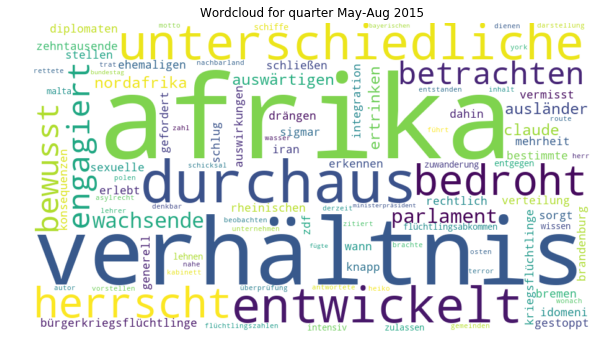

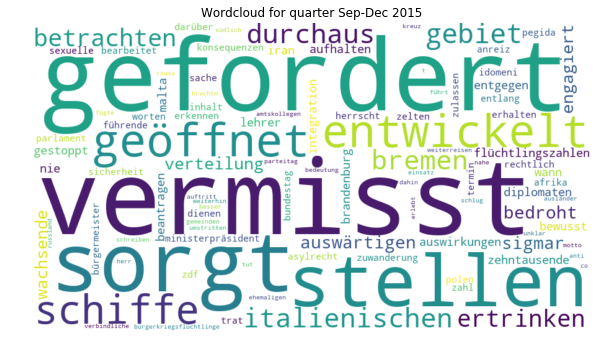

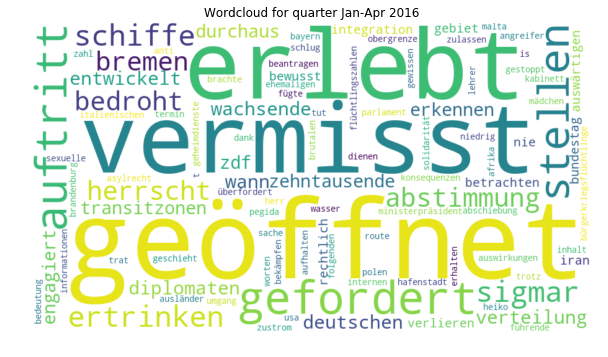

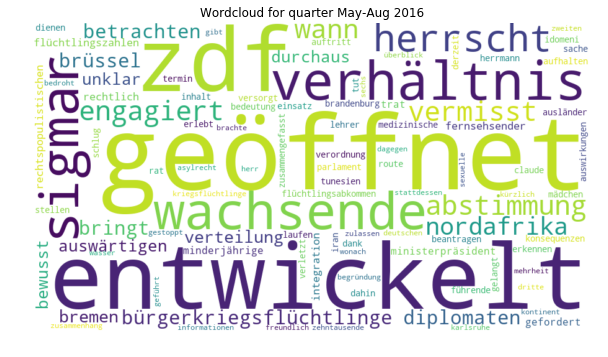

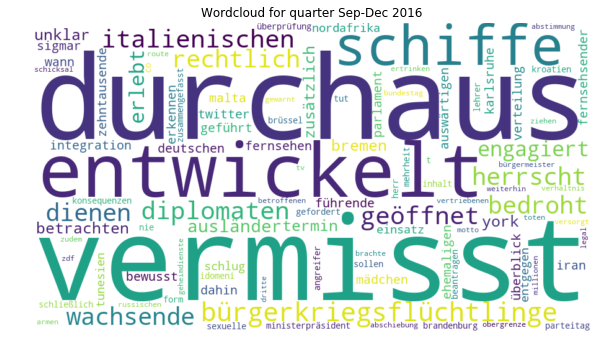

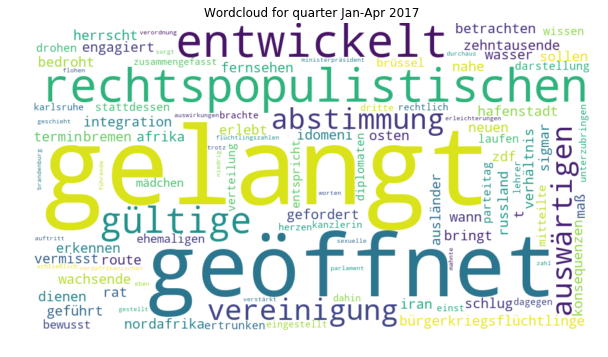

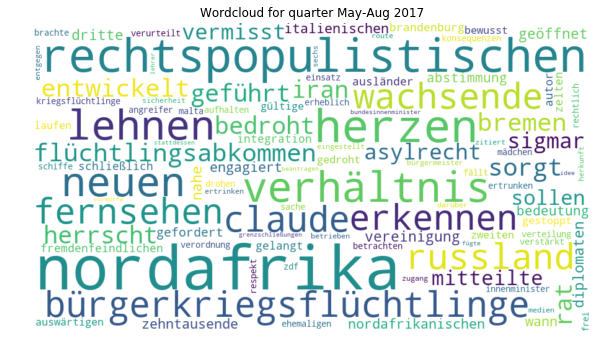

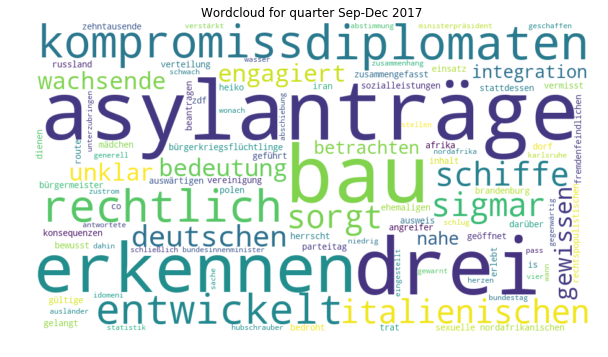

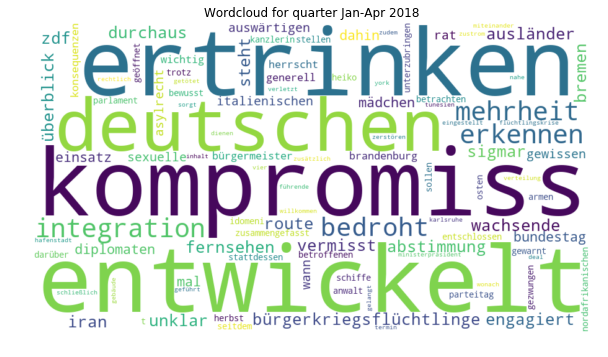

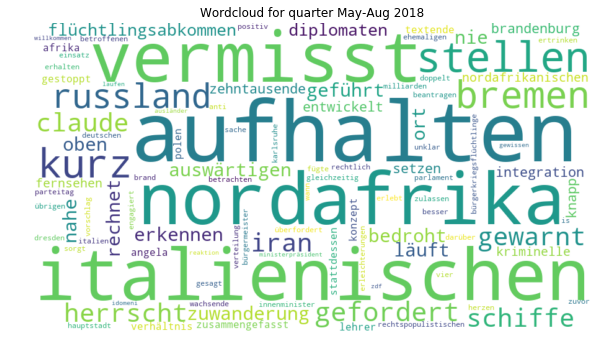

In [34]:
for i, q in enumerate(quarter_label_list):
    visualize_wordcloud(dict_freqs_quarter, q, title[i], relative_scaling=0.3, background_color='white')

The selection of words and frequency calculation looks in principle good. There are clear differences over the time (i.e. when AfD start to grow on adepts -> "rechtspopulistischen"). 

On the other hand, there is clear noise generated by those words that are pretty frequent on one quarter and not that much in the others but still present (i.e. regarding the scandal between Böhmermann and Erdogan -> "zdf" or with the recent scandal about asylum in Bremen -> "bremen"). What we see is that the frequency of these words is high on the right quarter but higher than it should be in the other quarters.

One alternative to reduce this noise could be by considering all articles per quarter as the same document and normalizing by documents per quarters but min/max frequency parameters of the TF-IDF need to be accuratelly fine-tuned in order to not create new artifacts.